# Studies on multi-controlled Toffoli decomposition

Valter Uotila, PhD student, University of Helsinki

This is a solution proposal for Classiq Coding Challenge where the problem is to decompose 14-control qubit toffoli gate into two and single qubit gates using max 5 ancilla qubits. The document has somewhat esseistic style because I tend to think by writing. Instead of focusing on the problem, I will study it considering the cases that we do not use ancilla qubits vs. we use up to five ancilla qubits. This comparison should point out how important ancialla qubits are in order to implement decompositions.

Because number 14 feels more or less quite arbitrary and it is also quite large, this code calculates a possible decomposition for any given number of control qubits. The idea is heavily based on the [classical book of Niels and Chuang](http://csis.pace.edu/~ctappert/cs837-19spring/QC-textbook.pdf) and the [excellent blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney. Also, the paper [Elementary gates for quantum computation](https://arxiv.org/abs/quant-ph/9503016v1) has been useful. Maybe everyone opens first the classical book of Niels and Chuang. One can find there the following exercise:

_**Exercise 4.29: Find a circuit containing $\mathcal{O}(n^2)$ Toffoli, CNOT and single qubits gates which implements a $C^n(X)$ gate for $n > 3$ using no work qubits.**_

This exercise appears to be surprisingly deep and hard. It is also connected to the problem in the competition although it does not include the idea of minimal depth. The [blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney is about this exercise.

My own contribution is the explanation in this document and the implementation that works for any multi-control Toffoli. I completed the implementation with Pennylane because Amazon Braket and many systems support it better than Qiskit. But I will use Qiskit to describe and visualize the method. For the case when we do not use ancialla qubits, the circuit becomes unpractically long. But I think this points out the power of quantum computing: every added ancilla qubit makes the circuit depth much shorter. 

**Table of contents:**

1. Solution proposal without ancilla qubits
    1. Implementation of a simple function that returns square roots for NOT gate
    2. Iteratively decompose using square root gates
2. Solution proposal with ancilla qubits (but not really quantum)
    1. Iteratively decompose multi-control toffoli gates
3. Testing 14 qubits multi-control Toffoli gate with ancilla qubits
4. Is it necessary to be always right?
5. Use ZH-calculus to optimize T-count
    1. Implementation of ZH

In [1]:
import json
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import SXGate, SGate, TGate, IGate, MCXGate

## Solution proposal without ancilla qubits

### Square roots of NOT gate and finding fundamental decompositions from Niels and Chuang

As Gidney explains in the [blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html), every logical quantum gate has the corresponding square root gate. When we note the fact that diagonal matrices are easy to square and 
$$
Z = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix},
$$
we obtain that 
$$
\sqrt[n]{Z} = \begin{bmatrix}
1 & 0 \\
0 & e^{i\frac{\pi}{n}}
\end{bmatrix}.
$$

When we change the computational basis to Hadamard -basis, taking the square roots become (at least theoretically) easier: $X = HZH$. This is also the reason for Hadamard-gates in the example decomposition in the Classiq's problem description. The $T$-gates and $S$-gates are the certain square roots of $Z$-gate, $T = \sqrt[4]{Z}$ and $S = \sqrt[2]{Z}$. So actually $T$ and $S$ gates are just a clever way to hide $X$ gates in the decomposition! Gidney reads Niels and Chuang very carefully and notices the power of the following circuit which corresponds to the Toffoli gate:

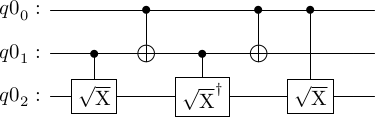

In [2]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.append(SXGate().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SXGate().inverse().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SXGate().control(), [qr[0], qr[2]])

circuit.draw(output='latex')

This circuit corresponds to the Toffoli case $V = (1-i)(I+iX)/2$ presented in Figure 4.8 in Niels and Chuang. Furthermore we can change the basis to Hadamard. Recall that $H\sqrt{X}H = \sqrt{Z} = S$. Thus we can write:

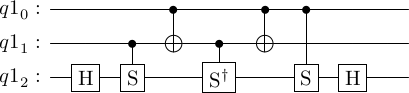

In [3]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)
circuit.append(SGate().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SGate().inverse().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SGate().control(), [qr[0], qr[2]])
circuit.h(2)

circuit.draw(output='latex')

If one wants a still bit more concrete visualition of the circuit, it is easy [to construct it to Quirk](https://algassert.com/quirk#circuit={%22cols%22:[[1,1,%22H%22],[1,%22%E2%80%A2%22,%22Z^%C2%BD%22],[%22%E2%80%A2%22,%22X%22],[1,%22%E2%80%A2%22,%22Z^-%C2%BD%22],[%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,%22Z^%C2%BD%22],[1,1,%22H%22]]}) and check that is encodes the Toffoli gate. The circuit also encodes multi-control Toffoli gate when we consider that the first wire is a bundle of multiple wires.

But this construction does not fullfill the requirement of the exercise 4.9 nor the competition description since the control bits are attached to square root and $S$ gates which is not allowed. Careful reading of Niels and Chuang solves this problem as Gidney points out. We can express the controlled-square root gates (also $S$ gates) above using the following decomposition that is presented in Figure 4.6 in Niels and Chuang. After all, this decomposition is quite well known and classical result. For an arbitrary unitary gate $U$, who is controlled by a single qubit, the decomposition is:

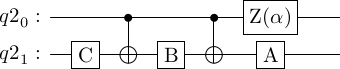

In [4]:
qr = QuantumRegister(2)
circuit = QuantumCircuit(qr)

# This circuit is just to visualization and the identity gate is simply a place holder for the labels
circuit.append(IGate(label = "C"), [qr[1]])
circuit.cx(0, 1)
circuit.append(IGate(label = "B"), [qr[1]])
circuit.cx(0, 1)
circuit.append(IGate(label = "A"), [qr[1]])
circuit.append(IGate(label = "Z(\\alpha)"), [qr[0]])

circuit.draw(output='latex')

where
$$
Z(\alpha) = \begin{bmatrix}
1 & 0 \\
0 & e^{i\alpha}
\end{bmatrix}
$$
and $Z(\alpha)AXBXC = U$ and $ABC = I$.

If we compare this construction to Figure 4.9 in Niels and Chuang, we can notice that $A = T$, $B = T^{\dagger}$, $C = I$ and $Z(\alpha) = T$ when we have the controlled $S$ gate. Now $ABC = TT^{\dagger} = I$ and $e^{(i\alpha)}AXBX = S$. So we can deduce that the following circuit implements controlled-$S$ gate:

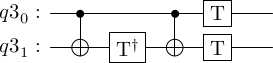

In [5]:
qr = QuantumRegister(2)
circuit = QuantumCircuit(qr)

# This circuit is just to visualization and the identity gate is simply a place holder for the labels
circuit.cx(0, 1)
circuit.append(TGate().inverse(), [qr[1]])
circuit.cx(0, 1)
circuit.append(TGate(), [qr[1]])
circuit.append(TGate(), [qr[0]])

circuit.draw(output='latex')

We can substitute the decomposition above into the circuit with controlled $S$ gates. We then obtain:

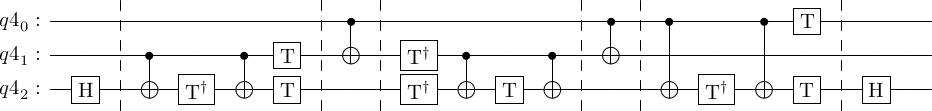

In [6]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)

# First substitution
# circuit.append(SGate().control(), [qr[1], qr[2]])

circuit.barrier()
circuit.cx(1, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(1, 2)
circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[1]])
circuit.barrier()


circuit.cx(0, 1)

# Second substitution for inverse S
# circuit.append(SGate().inverse().control(), [qr[1], qr[2]])

circuit.barrier()
circuit.append(TGate().inverse(), [qr[1]])
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(1, 2)
circuit.append(TGate(), [qr[2]])
circuit.cx(1, 2)
circuit.barrier()

circuit.cx(0, 1)

# Third substitution
#circuit.append(SGate().control(), [qr[0], qr[2]])

circuit.barrier()
circuit.cx(0, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[0]])
circuit.barrier()

circuit.h(2)

circuit.draw(output='latex')

which can be simplied to the following circuit:

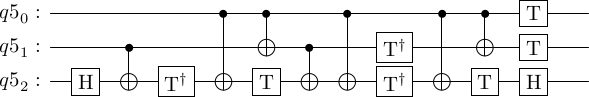

In [7]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)

circuit.cx(1, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.append(TGate(), [qr[2]])

circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.cx(0, 2)

circuit.append(TGate().inverse(), [qr[1]])
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.cx(0, 1)

circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[1]])
circuit.append(TGate(), [qr[0]])

circuit.h(2)

circuit.draw(output='latex')

We see that the depth of this circuit ([see the circuit in Quirk](https://algassert.com/quirk#circuit={%22cols%22:[[%22X%22,%22X%22,%22X%22],[1,1,%22H%22],[1,%22%E2%80%A2%22,%22X%22],[1,1,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[1,1,%22Z^%C2%BC%22],[%22%E2%80%A2%22,%22X%22],[1,%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,%22X%22],[1,%22Z^-%C2%BC%22,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[%22%E2%80%A2%22,%22X%22],[%22Z^%C2%BC%22,%22Z^%C2%BC%22,%22Z^%C2%BC%22],[1,1,%22H%22]]})) is smaller than the one Niels and Chuang represent but not better than in the problem description example. The circuit in the Classiq's problem description has a mistake: the fourth CNOT should be between $q_0$ and $q_2$ not between $q_1$ and $q_2$. The correct circuit is [here](https://algassert.com/quirk#circuit={%22cols%22:[[1,1,%22H%22],[1,%22%E2%80%A2%22,%22X%22],[1,1,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[1,1,%22Z^%C2%BC%22],[1,%22%E2%80%A2%22,%22X%22],[1,%22Z^%C2%BC%22,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[%22%E2%80%A2%22,%22X%22],[1,1,%22Z^%C2%BC%22],[1,%22Z^-%C2%BC%22],[%22Z^%C2%BC%22,1,%22H%22],[%22%E2%80%A2%22,%22X%22]]}). The number of gates is the same in all of the circuits.

### Iteratively and automatically decompose larger multi-control Toffoli gates

In this section I code a program that iteratively decomposes multi-toffoli gates into the previously represented smaller circuits. In my opinion Pennylane supports better gates based on custom unitaries, so I develop the algorithm using it. Algorithm iteratively removes all the multi-control gates from the circuit expressed in the cell [3]. Note that the circuit in cell [3] does not draw these wires but we consider that the first wire is a bundle of wires.

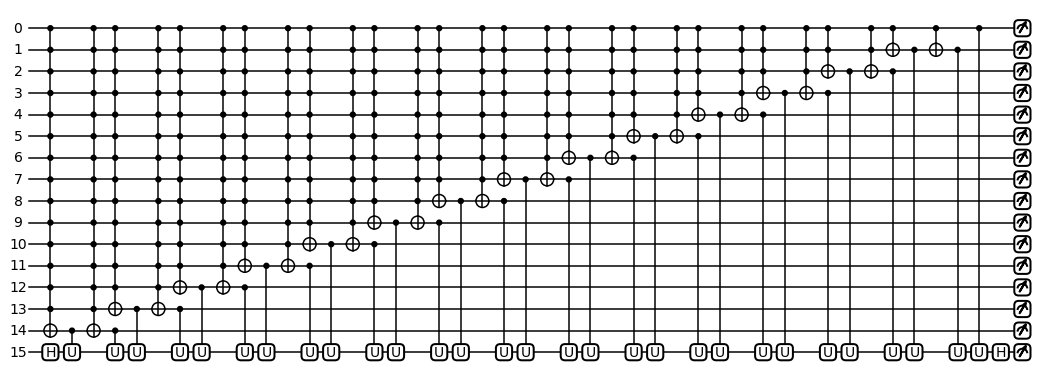

In [68]:
n_ctrl = 14 # number of control qubits
target = n_ctrl + 1
dev = qml.device("default.qubit", wires=target)

def get_square_root_z(n):
    return np.array([[1, 0], [0, np.exp(1j*np.pi/n)]])
    
@qml.qnode(dev)
def multi_Toffoli_step1_circuit(n_control_wires):
    all_ctrl_wires = range(n_control_wires + 1)
    target = n_control_wires + 1
    nth_square_root = target - n_control_wires
    square_root_matrix = None
    
    qml.Hadamard(wires=target)
    for i in all_ctrl_wires[:-1]:
        ctrl_wires = all_ctrl_wires[:-i - 1]
        n_ctrl_wires = len(ctrl_wires)
        square_root_matrix = get_square_root_z(2**i)
        square_root_matrix_inv = np.linalg.inv(square_root_matrix)
        
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        qml.ControlledQubitUnitary(square_root_matrix_inv, control_wires = n_ctrl_wires, wires = target)
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        qml.ControlledQubitUnitary(square_root_matrix, control_wires = n_ctrl_wires, wires = target)
    
    qml.ControlledQubitUnitary(square_root_matrix, control_wires = 0, wires = target)
    qml.Hadamard(wires=target)
    return qml.state()

qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(multi_Toffoli_step1_circuit, show_all_wires = True)(n_ctrl)
fig.set_size_inches(fig.get_size_inches()[0]*0.3, fig.get_size_inches()[1]*0.3)

Next we remove the single control gates that are not CNOTs. Here we apply the rule from cell [5]. Again, the cell [5] shows only the first step of the iteration. We implement the step by decomposing `qml.ControlledQubitUnitary` in the above code. Pennylane's renaming functionality does not work for custom qubit unitary gates so that the renames would also appear correctly in the matplotlib figure (as far as I checked the source code, this does not seem possible currently). So the Us in the above diagram are different. The following diagrams are not as pretty as the above but they show the U gates correctly and we can be sure that the implemented matrix is correct.

In [9]:
def controlled_qubit_unitary_decomposed(exponent, n_ctrl_wires, target, adjoint = False):
    square_root_matrix = get_square_root_z(2**exponent)
    square_root_matrix_inv = np.linalg.inv(square_root_matrix)
    
    if adjoint:
        qml.QubitUnitary(square_root_matrix_inv, wires = n_ctrl_wires)
        qml.QubitUnitary(square_root_matrix_inv, wires = target)
        qml.CNOT(wires = [n_ctrl_wires, target])
        qml.QubitUnitary(square_root_matrix, wires = target)
        qml.CNOT(wires = [n_ctrl_wires, target])
    else:
        qml.CNOT(wires = [n_ctrl_wires, target])
        qml.QubitUnitary(square_root_matrix_inv, wires = target)
        qml.CNOT(wires = [n_ctrl_wires, target])
        qml.QubitUnitary(square_root_matrix, wires = target)
        qml.QubitUnitary(square_root_matrix, wires = n_ctrl_wires)
    

In [10]:
@qml.qnode(dev)
def multi_Toffoli_step2_circuit(n_control_wires):
    all_ctrl_wires = range(n_control_wires + 1)
    target = n_control_wires + 1
    nth_square_root = target - n_control_wires
    square_root_matrix = None
    
    qml.Hadamard(wires=target)
    for i in all_ctrl_wires[:-1]:
        ctrl_wires = all_ctrl_wires[:-i - 1]
        n_ctrl_wires = len(ctrl_wires)
        square_root_matrix = get_square_root_z(2**i)
        
        #qml.Barrier(wires = range(target + 1))
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        controlled_qubit_unitary_decomposed(i+1, n_ctrl_wires, target, adjoint = True)
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        controlled_qubit_unitary_decomposed(i+1, n_ctrl_wires, target, adjoint = False)
        
    #qml.Barrier(wires = range(target +1))
    controlled_qubit_unitary_decomposed(len(all_ctrl_wires[:-1]), 0, target, adjoint = False)
    qml.Hadamard(wires=target)
    return qml.state()

# One can also visualize the code with matplotlib but then the QubitUnatires won't show correctly
# because I was not able to overwrite the default name 'U'
# There might be a fix for this visualization problem

#qml.drawer.use_style('black_white')
#fig, ax = qml.drawer.draw_mpl(multi_Toffoli_step2_circuit, show_all_wires = True, show_matrices=True)(n_ctrl)
#fig.set_size_inches(fig.get_size_inches()[0]*0.4, fig.get_size_inches()[1]*0.4)

print(qml.drawer.draw(multi_Toffoli_step2_circuit, show_all_wires=True, decimals=5, max_length=250, show_matrices=True)(n_ctrl))

 0: ─╭C─────────────────────╭C─╭C──────────────────────────────────────╭C─╭C──────────────────────────────────────╭C─╭C──────────────────────────────────────╭C─╭C──────────────────────────────────────╭C─╭C─────────────────────────────────────────╭C
 1: ─├C─────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C─────────────────────────────────────────├C
 2: ─├C─────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C─────────────────────────────────────────├C
 3: ─├C─────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C──────────────────────────────────────├C─├C─────────────────────────────────────────├C
 4: 

Finally we decompose multi-control Toffoli gates. At each step, the number of required control qubits is reduced by one. Practically this means that we  recirsively execute the above code for each `qml.MultiControlledX`. As one can expect the output circuit is long but it does not use any ancilla qubits.

In [11]:
def multi_Toffoli_step3_circuit(n_control_wires):
    all_ctrl_wires = range(n_control_wires + 1)
    target = n_control_wires + 1
    nth_square_root = target - n_control_wires
    square_root_matrix = None
    
    qml.Hadamard(wires=target)
    for i in all_ctrl_wires[:-1]:
        ctrl_wires = all_ctrl_wires[:-i - 1]
        n_ctrl_wires = len(ctrl_wires)
        square_root_matrix = get_square_root_z(2**i)
        
        #qml.Barrier(wires = range(target + 1))
        multi_Toffoli_step3_circuit(n_ctrl_wires - 1)
        controlled_qubit_unitary_decomposed(i+1, n_ctrl_wires, target, adjoint = True)
        multi_Toffoli_step3_circuit(n_ctrl_wires - 1)
        controlled_qubit_unitary_decomposed(i+1, n_ctrl_wires, target, adjoint = False)
        
    #qml.Barrier(wires = range(target +1))
    controlled_qubit_unitary_decomposed(len(all_ctrl_wires[:-1]), 0, target, adjoint = False)
    qml.Hadamard(wires=target)

The 14-conrol qubit Toffoli produces unpractically long circuit to be visualized, so I demonstrate the code with 5-control qubits (which is very long also!). The great fact about the implementation is that we need only 11 single qubit gates in the circuit and this count includes Hadamard.

In [12]:
n_ctrl = 5
@qml.qnode(dev)
def multi_Toffoli_final(n_control_wires):
    multi_Toffoli_step3_circuit(n_control_wires)
    return qml.state()

print(qml.drawer.draw(multi_Toffoli_final, show_all_wires=False, decimals=5, max_length=250, show_matrices=True)(n_ctrl))

0: ────╭C────────────╭C──U(M1)───────────────────────────╭C────────╭C──U(M1)────────────────────────╭C────────╭C──U(M2)─╭C────────╭C──U(M1)──────────────────────────────────╭C────────╭C──U(M1)────────────────────────╭C────────╭C──U(M2)─╭C───────
1: ──H─╰X──────U(M1)─╰X──U(M1)──H──U(M0)─╭C────────╭C──H─╰X──U(M1)─╰X──U(M1)──H─╭C────────╭C──U(M2)─│─────────│───H─────╰X──U(M1)─╰X──U(M1)──H──U(M0)────────╭C────────╭C──H─╰X──U(M1)─╰X──U(M1)──H─╭C────────╭C──U(M2)─│─────────│───H─────╰X──U(M1)
2: ──H──U(M0)────────────────────────────╰X──U(M2)─╰X───────────────────────────╰X──U(M0)─╰X──U(M2)─╰X──U(M0)─╰X──U(M2)──H──U(M0)─╭C────────╭C──H──────U(M0)─╰X──U(M2)─╰X───────────────────────────╰X──U(M0)─╰X──U(M2)─╰X──U(M0)─╰X──U(M2)──H─╭C────
3: ──H──U(M0)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╰X──U(M2)─╰X─────────────────────────────────────────────────────────────────────────────────────────────────╰X────
4: ──H──U(M0)───

Even if the circuit is unpractically long to be visualized, we can calculate its depth and gate count easily with Pennylane. The framework offers also other possibly interesting information about the circuit. We can run the circuit in simulators and on a real quantum device.

In [13]:
# Also command multi_Toffoli_final.qtape.get_depth() might be useful
n_ctrl = 7
print("The specs of " + str(n_ctrl) + " control qubits Toffoli gate without ancilla qubits is: ")
print(json.dumps(qml.specs(multi_Toffoli_final)(n_ctrl), indent=4, sort_keys=True))

The specs of 7 control qubits Toffoli gate without ancilla qubits is: 
{
    "depth": 17012,
    "device_name": "default.qubit.autograd",
    "diff_method": "best",
    "expansion_strategy": "gradient",
    "gate_sizes": {
        "1": 17493,
        "2": 8746
    },
    "gate_types": {
        "CNOT": 8746,
        "Hadamard": 4374,
        "QubitUnitary": 13119
    },
    "gradient_fn": "backprop",
    "gradient_options": {},
    "interface": "autograd",
    "num_device_wires": 15,
    "num_diagonalizing_gates": 0,
    "num_observables": 1,
    "num_operations": 26239,
    "num_trainable_params": 13119,
    "num_used_wires": 9
}


## Solution proposal with ancilla qubits (but not really quantum)

As the previous part showed, we really should use ancilla qubits because every time when we remove an ancilla qubit, the decomposition seems to get exponentially more complicated. If one studies the 14-control qubit Toffoli gate a bit, we can easily see that we can decompose it in the following manner. Also, the [blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney points out this. See the [Quirk demonstration](https://algassert.com/quirk#circuit={%22cols%22:[[%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,%22X%22],[1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22,%22%E2%80%A2%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,%22X%22]]}) for 8 control-qubit Toffoli. The idea is that every ancialla qubit divides the construction into two multi-control Toffoli gates which have half of the number of the qubits than the original multi-control Toffoli.

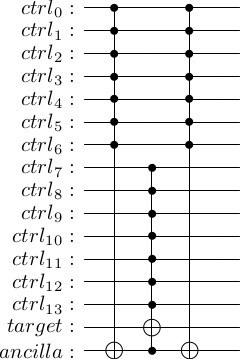

In [14]:
qr = QuantumRegister(14, 'ctrl')
target = QuantumRegister(1, 'target')
anc = QuantumRegister(1, 'ancilla')
circuit = QuantumCircuit(qr, target, anc)

gate7 = MCXGate(7)
gate8 = MCXGate(8)

controls7 = [qr[i] for i in range(7)]
controls8 = [qr[i] for i in range(7, 14)]

circuit.append(gate7, controls7 + [anc[0]])
circuit.append(gate8, controls8 + [anc[0], target[0]])
circuit.append(gate7, controls7 + [anc[0]])

circuit.draw(output='latex')

See the [Quirk example for 12-qubit case](https://algassert.com/quirk#circuit={%22cols%22:[[%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,%22X%22,%22%E2%80%A2%22],[1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,%22X%22],[1,1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,%22X%22],[1,1,1,1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,%22X%22],[1,1,1,1,1,1,1,1,1,1,1,1,%22X%22,%22%E2%80%A2%22],[1,1,1,1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,%22X%22],[1,1,1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,%22X%22],[1,1,1,1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,1,1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,%22X%22,%22%E2%80%A2%22],[1,1,1,%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,1,1,%22X%22],[1,1,%22%E2%80%A2%22,1,1,1,1,1,1,1,1,1,1,1,%22X%22]]}) when we use three ancilla qubits and Toffoli gates. Toffoli-gates can be decomposed using the previous decompositions. Let's code the above example with Pennylane:

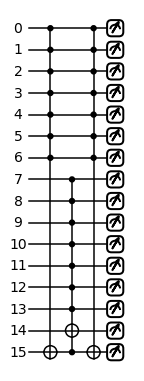

In [15]:
import math
n_ctrl = 14 # number of control qubits
target = n_ctrl + 1
dev = qml.device("default.qubit", wires=target)

@qml.qnode(dev)
def make_it_half(n_ctrl):
    target = n_ctrl
    ctrl_wires1 = list(range(math.ceil(n_ctrl/2)))
    ctrl_wires2 = list(range(math.floor(n_ctrl/2), n_ctrl)) + [target + 1]
    
    qml.MultiControlledX(control_wires = ctrl_wires1, wires = target + 1)
    qml.MultiControlledX(control_wires = ctrl_wires2, wires = target)
    qml.MultiControlledX(control_wires = ctrl_wires1, wires = target + 1)
    
    return qml.state()

qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(make_it_half, wire_order=list(range(target)), show_all_wires = True)(n_ctrl)
fig.set_size_inches(fig.get_size_inches()[0]*0.3, fig.get_size_inches()[1]*0.3)

Next we recursively replace `MultiControlledX` until we have expressed everything in terms of Toffoli-gates:

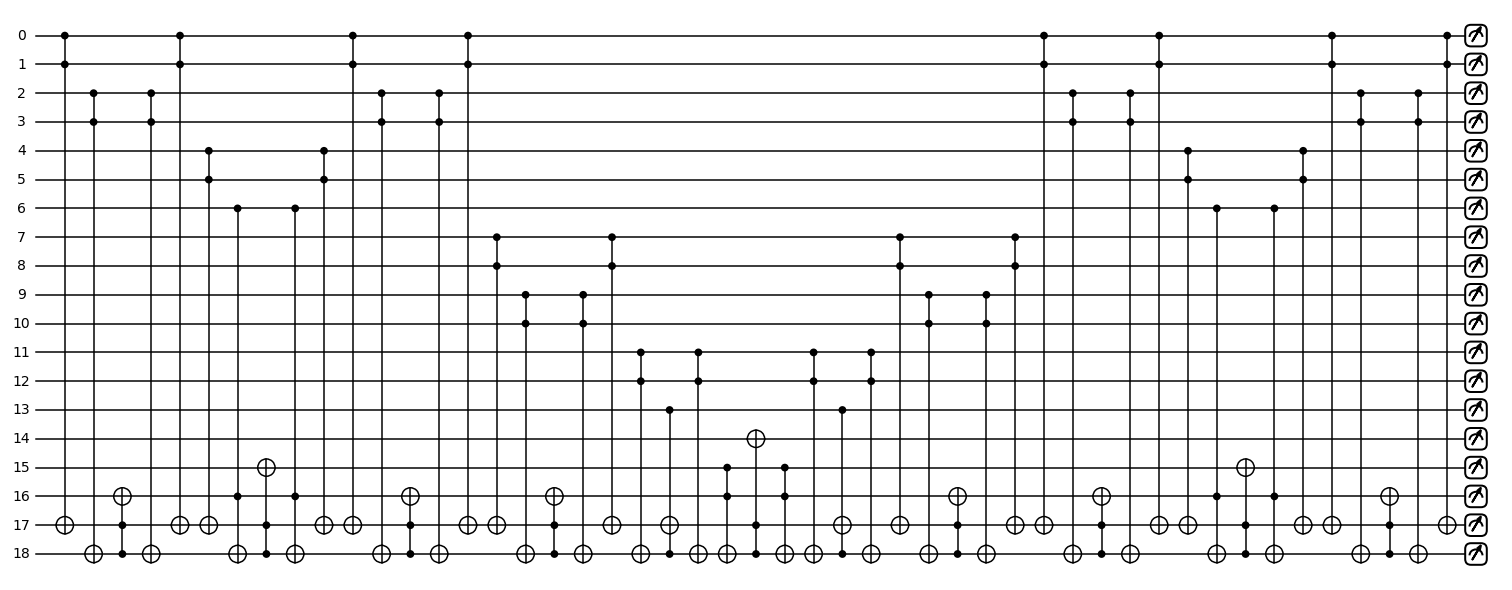

In [55]:
dev = qml.device("default.qubit", wires=20)    

def make_it_half_recursive(ctrl_wires, target):
    n_ctrl = len(ctrl_wires)
    ctrl_indices1 = math.ceil(n_ctrl/2)
    
    if n_ctrl == 1:
        qml.Toffoli(wires = [ctrl_wires[0], target + 1, target])
    elif n_ctrl == 2:
        qml.Toffoli(wires = [ctrl_wires[0], ctrl_wires[1], target])
    else:
        new_target = max(max(ctrl_wires), target)
        make_it_half_recursive(ctrl_wires[:ctrl_indices1], new_target + 1)
        make_it_half_recursive(ctrl_wires[ctrl_indices1:] + [new_target + 1], target)
        make_it_half_recursive(ctrl_wires[:ctrl_indices1], new_target + 1)

@qml.qnode(dev)
def full_algorithm(ctrl_wires, target):
    make_it_half_recursive(ctrl_wires, target)
    return qml.state()

qml.drawer.use_style('black_white')
x = 14
fig, ax = qml.draw_mpl(full_algorithm, wire_order=list(range(20)), show_all_wires = False)(list(range(x)), x)
fig.set_size_inches(fig.get_size_inches()[0]*0.4, fig.get_size_inches()[1]*0.4)

In [52]:
print("The specs of 14 control qubits Toffoli gate with ancilla qubits is: ")
print(json.dumps(qml.specs(full_algorithm)(list(range(14)), 14), indent=4, sort_keys=True))

The specs of 14 control qubits Toffoli gate with ancilla qubits is: 
{
    "depth": 33,
    "device_name": "default.qubit.autograd",
    "diff_method": "best",
    "expansion_strategy": "gradient",
    "gate_sizes": {
        "3": 49
    },
    "gate_types": {
        "Toffoli": 49
    },
    "gradient_fn": "backprop",
    "gradient_options": {},
    "interface": "autograd",
    "num_device_wires": 17,
    "num_diagonalizing_gates": 0,
    "num_observables": 1,
    "num_operations": 49,
    "num_trainable_params": 0,
    "num_used_wires": 19
}


Next we replace Toffoli-gates with the decomposition from cell [6]:

In [58]:
def toffoli_decomposition(ctrl1, ctrl2, target):
    qml.Hadamard(wires = target)
    qml.CNOT(wires = [ctrl2, target])
    qml.adjoint(qml.T)(wires = target)
    qml.CNOT(wires=[ctrl1, target])
    qml.CNOT(wires=[ctrl1, ctrl2])
    qml.T(wires = target)
    qml.CNOT(wires=[ctrl2, target])
    qml.CNOT(wires=[ctrl1, target])
    qml.adjoint(qml.T)(wires = target)
    qml.adjoint(qml.T)(wires = ctrl2)
    qml.CNOT(wires=[ctrl1, target])
    qml.CNOT(wires=[ctrl1, ctrl2])
    qml.T(wires = target)
    qml.T(wires = ctrl1)
    qml.T(wires = ctrl2)
    qml.Hadamard(wires = target)

In [62]:
dev = qml.device("default.qubit", wires=20)    

def make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires, target):
    n_ctrl = len(ctrl_wires)
    ctrl_indices1 = math.ceil(n_ctrl/2)
    
    if n_ctrl == 1:
        toffoli_decomposition(ctrl_wires[0], target + 1, target)
    elif n_ctrl == 2:
        toffoli_decomposition(ctrl_wires[0], ctrl_wires[1], target)
    else:
        new_target = max(max(ctrl_wires), target)
        make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires[:ctrl_indices1], new_target + 1)
        make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires[ctrl_indices1:] + [new_target + 1], target)
        make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires[:ctrl_indices1], new_target + 1)

@qml.qnode(dev)
def final_full_algorithm(ctrl_wires, target):
    make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires, target)
    return qml.state()

qml.drawer.use_style('black_white')
x = 14
fig, ax = qml.draw_mpl(final_full_algorithm, wire_order=list(range(20)), show_all_wires = False)(list(range(x)), x)
#fig.set_size_inches(fig.get_size_inches()[0]*0.4, fig.get_size_inches()[1]*0.4)
fig.savefig('final_circuit')

To see the circuit properly, see the final_circuit.png file

In [63]:
print("The specs of 14 control qubits Toffoli gate with four ancilla qubits is: ")
print(json.dumps(qml.specs(full_algorithm)(list(range(14)), 14), indent=4, sort_keys=True))

The specs of 14 control qubits Toffoli gate with four ancilla qubits is: 
{
    "depth": 352,
    "device_name": "default.qubit.autograd",
    "diff_method": "best",
    "expansion_strategy": "gradient",
    "gate_sizes": {
        "1": 441,
        "2": 343
    },
    "gate_types": {
        "CNOT": 343,
        "Hadamard": 98,
        "T": 196,
        "T.inv": 147
    },
    "gradient_fn": "backprop",
    "gradient_options": {},
    "interface": "autograd",
    "num_device_wires": 20,
    "num_diagonalizing_gates": 0,
    "num_observables": 1,
    "num_operations": 784,
    "num_trainable_params": 0,
    "num_used_wires": 19
}


## Testing 14 qubits multi-control Toffoli gate with ancilla qubits

We test the code so that we create Hadamard transform over the 14 control qubits. We know that only one state (one containing 14 times $|1\rangle$) among $2^{14}$ produces output 1 when the target qubit is measured. This means that we should measure 1 from the target qubit with the probability $\frac{1}{2^{14}} = 1/16384 = 0.000061035... \approx 6.1035\times 10^{-5}$. Any mistake in the code will affect this result remarkably.

In [87]:
dev = qml.device("lightning.qubit", wires=19)

@qml.qnode(dev)
def test_code(n):
    ctrl_wires, target = list(range(n)), n
    qml.broadcast(unitary=qml.Hadamard, pattern="single", wires=ctrl_wires)
    #qml.broadcast(unitary=qml.PauliX, pattern="single", wires=ctrl_wires)
    make_it_half_recursive_with_Toffoli_decomposition(ctrl_wires, target)
    return qml.probs(wires=[target])

print(test_code(14))

[9.99938965e-01 6.10351563e-05]


As we see the output probability to measure 1 is very close to `6.1035e-05`. This indicates that the decomposition is correct.

## Is it necessary to be always right?

Although I kind of hate the term _quantum machine learning_, I would need to learn it for my research. I think this would be a great and sufficiently simple example. So I modify the exercise so that I want to develop a parametrised quantum circuit so that it is optimized to simulate multi-control Toffoli gate. It would work so that we can know that it produces a correct value to the target qubit with certain trackable probability.